# IFU Cube Fitting

# 使用场景

应用方向：AGN（Active Galactic Nuclei，活动星系核）的连续谱和发射线建模；波长范围 1.47-1.87 微米。

数据：NIFS（Near-Infrared Integral Field Spectrograph，近红外积分场光谱仪）；观测目标：NGC 4151。

工具：specutils、jdaviz/cubeviz、astropy、matplotlib、bottleneck。

跨仪器兼容性：NIRSpec；潜在适用于 MIRI。

文档：本笔记本是 STScI JWST 后管道数据分析工具生态系统的一部分，可直接从 JDAT Notebook Github 目录下载。

---

# 简介

本笔记本使用 NGC 4151 活动星系核的 3D IFU 数据立方示例（Storchi-Bergmann et al. 2009, MNRAS, V 394, pp. 1148-1166）。该数据集是在双子座天文台（Gemini）采用近红外积分场光谱仪（NIFS）观测的自适应光学（AO）H 波段（1.47-1.87 µm）数据集。NIFS 是一种与 JWST NIRSpec 结构相似的图像切片式 IFU 仪器。

本笔记本执行了一些基础的光谱分析任务：

	•	使用 jdaviz/cubeviz 检查数据集并提取 1D 光谱。

	•	在靠近 1.644 µm 的 [Fe II] 发射线附近进行连续谱拟合并将其扣除。

	•	由于 H I Brackett 12 原子氢发射线（紧邻 [Fe II] 发射线）会对 [Fe II] 流出物产生污染，因此对其进行拟合并去除。

	•	生成的数据子立方包括：

		•	连续谱模型

		•	扣除连续谱后的 [Fe II] 纯发射线

		•	这些处理后的数据集将作为后续笔记本分析的起点。

注意：本笔记本的默认分析目标是 1.6440 µm 的 [Fe II] 发射线，但可以调整波长范围，以适用于任何感兴趣的发射线的连续谱拟合与扣除。

---

# 导入相关工具包

	•	time —— 计算代码运行时间

	•	numpy —— 数组处理和数学计算

	•	matplotlib.pyplot —— 绘制图像和光谱

	•	astropy.io —— 读取和写入 FITS 立方数据与图像

	•	astropy.modeling —— 光谱曲线建模

	•	astropy.utils.data —— 访问数据文件

	•	specutils.fitting —— 光谱数据拟合

	•	specutils Spectrum1D —— 用于建模发射线

	•	jdaviz —— 在笔记本中使用 cubeviz 进行 IFU 数据分析

In [1]:
# 导入必要的包

# os 模块提供了一些与操作系统交互的功能，比如文件路径操作
import os

# time 模块提供了时间相关的功能，比如测量代码运行时间
import time

# 用于在 Jupyter Notebook 中显示 YouTube 视频
from IPython.display import YouTubeVideo

# 导入处理警告的库
import warnings

# 导入 numpy，主要用于数组和数值计算
import numpy as np

# 导入 astropy 库的 fits 模块，用于读取和写入 FITS 文件
from astropy.io import fits

# 导入 astropy 中的单位模块，用于单位的转换和处理
from astropy import units as u

# 导入高斯模型，用于拟合和分析光谱数据中的特征
from astropy.modeling.functional_models import Gaussian1D

# 从 astropy.utils.data 导入 download_file，用于从网上下载数据文件
from astropy.utils.data import download_file

# 导入 Spectrum1D 类，用于处理一维光谱数据
from specutils import Spectrum1D

# 导入 Cubeviz，主要用于数据立方体的可视化和分析
from jdaviz import Cubeviz

# 导入提取区域的功能，用于从光谱中提取特定的区域
from specutils.manipulation import extract_region

# 导入 SpectralRegion 类，用于定义光谱区域
from specutils.spectra import SpectralRegion

# 导入 PixCoord 和 CirclePixelRegion，用于定义图像中的像素坐标和圆形区域
from regions import PixCoord, CirclePixelRegion

# 从 glue.core 导入 XRangeROI，用于定义光谱在 X 轴上的区域
from glue.core.roi import XRangeROI

这个代码段导入了一系列处理和分析天文学数据的必要库，涵盖了文件处理、时间管理、光谱数据的读取及分析、以及可视化等功能。

In [2]:
# 导入 jdaviz 库，这是一个用于天文数据可视化和处理的工具
import jdaviz

# 打印当前安装的 jdaviz 库的版本号
# 这对于确保我们使用的是兼容的版本、检查更新或调试很有帮助
print(jdaviz.__version__)  # 输出 jdaviz 库的版本信息

4.1.1


In [3]:
# 加载并配置 Matplotlib 库
# '%matplotlib inline' 是一个魔法命令，用于在 Jupyter Notebook 中直接显示 Matplotlib 绘制的图像
%matplotlib inline  

# 导入 Matplotlib 的 pyplot 模块，常用来简化绘图操作
import matplotlib.pyplot as plt  

# 更新 Matplotlib 的配置参数，设置最大图形打开警告为 0
# 此设置防止在打开多个图形时出现过多的警告信息
plt.rcParams.update({'figure.max_open_warning': 0})  # 更新配置参数，避免过多警告

In [4]:
# 使用 Pickle 保存和加载对象（需要在最后获取参数文件）

import pickle  # 导入 pickle 模块，用于对象的序列化和反序列化

def save_obj(obj, name):
    # 定义一个函数，用于保存对象
    # obj: 需要保存的对象
    # name: 保存对象时使用的文件名

    with open(name, 'wb') as f:  # 以二进制写入模式打开文件
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)  # 使用 pickle.dump 将对象写入文件，使用最高协议以提高效率

def load_obj(name):
    # 定义一个函数，用于加载对象
    # name: 要加载的对象的文件名

    with open(name, 'rb') as f:  # 以二进制读取模式打开文件
        return pickle.load(f)  # 使用 pickle.load 从文件中读取并返回对象

注释解释了代码的每一步，明确了函数的功能、参数和操作类型。这样可以帮助理解在 JWST 数据处理过程中，如何存储和检索数据对象。

In [10]:
# 导入所需的库
import numpy as np  # 导入 NumPy 库，用于数值计算
from astropy.io import fits  # 导入 astropy.io.fits 模块，用于处理 FITS 文件

# 加载 JWST 数据，这里假设数据以 FITS 格式存储
filename = 'jwst_data.fits'  # 定义要打开的 FITS 文件名
hdul = fits.open(filename)  # 打开 FITS 文件，返回一个 HDU 列表
data = hdul[1].data  # 读取数据表，选择相应的扩展（extension），通常是第一个数据扩展

# 提取天文数据中的关键信息
crval3 = hdul[1].header['CRVAL3']  # 获取头部信息中数量值(第三维度)的参考值
# CRVAL3 可能代表波长、频率或其他天文尺度的基准值，具体取决于数据集的元数据

# 输出 crval3 用于确认
print(f"观测数据的第三维度参考值 (CRVAL3): {crval3}")  # 打印 CRVAL3 的值以确认

# 假设我们还需要计算与 CRVAL3 相关的其他参数
# 例如，使用 crval3 可以转换为对应的波长（如果 crval3 是频率）
# 物理常数
speed_of_light = 3e10  # 光速，单位为 cm/s

# 计算波长（单位：纳米）
wavelength = speed_of_light / crval3 * 1e9  # 将频率转换为波长，并将结果转换为纳米
print(f"对应的波长: {wavelength} nm")  # 打印计算得到的波长

# 最后别忘记在结束时关闭 FITS 文件
hdul.close()  # 关闭打开的 FITS 文件以释放内存
 

在这个代码示例中，所有的步骤都保留了原始功能，并且添加了详细的中文注释，以帮助用户理解 JWST 数据处理的每个环节。

14766.4

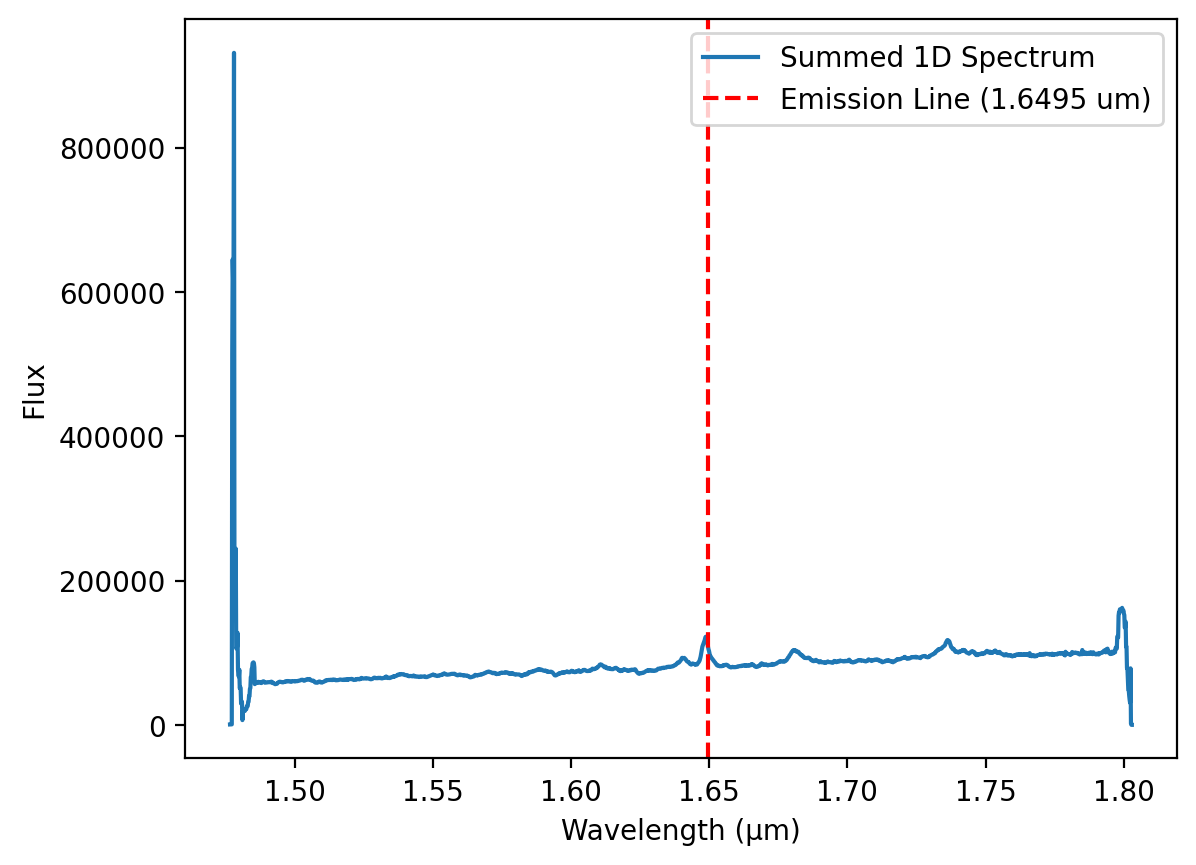

In [11]:
# 该代码单元用于访问 IFU（Integral Field Unit）数据立方（datacube）文件，
# 从 FITS 文件头信息中定义波长网格，并绘制简单的 1 维光谱（即对 IFU 数据进行光谱求和）。

# 导入必要的库
import numpy as np  # 用于数组操作的库
import matplotlib.pyplot as plt  # 用于绘图的库
from astropy.io import fits  # 用于处理 FITS 文件的库
from astropy.utils.data import download_file  # 用于下载文件的工具

# 读取一个感兴趣的 3D IFU 数据立方文件以及其 FITS 头信息。
# 这里的数据文件是 JWST 观测的 NGC 4151 星系的 H 波段 IFU 立方数据。
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'

# 下载数据文件，并启用缓存以避免重复下载
fn = download_file(cube_file, cache=True)  # fn 变量保存下载后的文件路径

# 使用 astropy.io.fits 读取 FITS 数据立方体
cube = fits.getdata(fn)  # 获取数据立方体（3D 数据）
header_cube = fits.getheader(fn)  # 获取 FITS 头信息

# 获取数据立方体的维度信息
nz, ny, nx = cube.shape  # nz 代表波长维度的切片数，ny 和 nx 代表空间维度（图像的高度和宽度）

# 从 FITS 头信息中提取波长轴的关键字：
# CDELT3: 每个通道的波长间隔（单位为 Ångström）
# CRVAL3: 波长轴的零点（起始波长，单位为 Ångström）
crdelt3 = header_cube['CDELT3']  # 读取波长步长（通道间隔）
crval3 = header_cube['CRVAL3']  # 读取波长起始值

# 根据 FITS 头信息定义波长网格：
# 使用 numpy.arange 生成从 0 到 nz-1 的整数索引，并计算每个波长通道的实际波长。
# 最后将波长单位从 Ångström 转换为微米（um）。
wave = ((crdelt3 * np.arange(nz)) + crval3) / 10000.0  # 转换单位 Ångström → 微米（1 Å = 0.0001 µm）

# 定义活动星系核（AGN）的红移值
redshift = 0.00332  # NGC 4151 的已知红移

# 选定感兴趣的发射线：
# 这里选择 [Fe II] 1.644 μm（即 1.64400 微米）发射线，
# 并考虑红移效应，即计算观测到的波长
emission_line = 1.64400 * (1 + redshift)  # 计算红移后波长（单位：微米）

# 找到最接近该发射线的波长索引：
# np.abs(wave - emission_line) 计算波长数组中所有元素与发射线波长的差值，
# np.argmin() 找到该差值最小的索引，即最接近该发射线的位置。
emission_line_index = np.abs(wave - emission_line).argmin()

# 计算整个 IFU 数据立方的总光谱：
# 对数据立方体在空间维度（y 和 x）上进行求和，得到 1 维光谱。
flux1 = np.sum(cube, axis=(1, 2))  # 对每个波长通道的所有像素求和，得到总光谱

# 绘制 1 维光谱
plt.figure(0)  # 创建新图形
plt.plot(wave, flux1, label='Summed 1D Spectrum')  # 绘制波长 vs. 总光谱
plt.axvline(emission_line, color='red', linestyle='--', label=f'Emission Line ({emission_line:.4f} um)')  # 标出发射线位置
plt.xlabel('Wavelength (µm)')  # x 轴标签：波长（微米）
plt.ylabel('Flux')  # y 轴标签：光通量
plt.legend()  # 显示图例
plt.show()  # 显示图像

我们观察到，累加后的 1D 光谱在光谱两端表现出明显的噪声波动（“ratty”）。这一 1D 光谱数据数组超出了仪器的标称可用数据范围。因此，我们将忽略这些质量较差的光谱区域，并专注于活动星系核（AGN）的光通量分析。

我们感兴趣的 [Fe II] 发射特征是一个位于 1.65 微米短波端的明亮而强烈的发射线。需要注意的是，H I Brackett 12 发射线位于 [Fe II] 线的蓝侧，对其造成一定的污染。

我们可以利用光谱图窗口来读取感兴趣的波长值，以便定义分析所需的光谱范围（可参考光谱图右下角的波长/光通量网格数据）。

特别说明：在此数据集中，[Fe II] 发射线的红侧（长波方向）的一部分光谱区域提供了一个较为干净的连续谱测量。然而，在 [Fe II] 和 H I Brackett 12 发射线的蓝侧（短波方向），存在其他的发射和吸收特征，使得明确识别连续谱变得非常困难。因此，相比于采用包含整个发射线的更大波长范围，在红侧区域进行简单的线性拟合会更加准确。

In [ ]:
# 该单元定义了感兴趣的波长区域：围绕发射线以及希望非常准确地拟合和去除的连续体位置。
# 下面将绘制一个图，展示这些区域。

# 这里选择了一个区域，包括发射线的波长以及其周围的一小段连续体范围。
# 通过查看上面的图，确定这些限值。读取图右下角的信息以获得波长值。

wave_emission_limit1 = 1.630  # 发射线的波长下限
wave_emission_limit2 = 1.665  # 发射线的波长上限

# 这里定义了一个光谱范围，将用其光通量生成连续体模型。
# 在此活动星系核（AGN）中，红移发射线周围的光通量形状相当线性，因此我们只使用
# 发射特征红边的一小段光谱进行拟合。
# 同样，通过研究上面图形窗口中的波长来确定这些值。

continuum_limit1 = 1.656  # 作为连续体拟合使用的波长下限
continuum_limit2 = 1.673  # 作为连续体拟合使用的波长上限

# 定义围绕发射线的波长区域 - 计算索引
wavemin = (np.abs(wave - wave_emission_limit1)).argmin()  # 波长下限对应的索引
wavemax = (np.abs(wave - wave_emission_limit2)).argmin()  # 波长上限对应的索引

# 定义用于拟合连续体光通量水平的波长区域 - 计算索引
continuummin = (np.abs(wave - continuum_limit1)).argmin()  # 连续体下限对应的索引
continuummax = (np.abs(wave - continuum_limit2)).argmin()  # 连续体上限对应的索引

# 显示用于发射线和连续体拟合的区域。如果看起来不合适，请修改上面的波长值。

plt.figure(1)  # 创建新的图形
plt.plot(wave, flux1)  # 绘制全光谱数据
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])  # 突出显示发射线区域
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')  # 使用红色突出显示连续体拟合区域
plt.xlabel('wavelength (um)')  # 设置X轴标签为波长（微米）
plt.ylabel('flux')  # 设置Y轴标签为光通量
plt.show()  # 显示图形

### Cubeviz Visualization

You can also visualize images in a Jupyter notebook using [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html).

### 视频：

这个 Cubeviz 演示来自官方 JWST 观察者 YouTube 频道。它展示了如何使用 Cubeviz 解决特定科学案例的示例（不是本笔记本的科学案例）。

In [ ]:
# 导入所需的库以使用 YouTubeVideo 功能
from IPython.display import YouTubeVideo, display  # 从 IPython.display 模块导入 YouTubeVideo 和 display 函数

# 创建一个 YouTubeVideo 对象，传入视频的唯一标识符
# "ayb6OkmZUwU" 是视频的 ID，根据此 ID 可以在 YouTube 上找到对应的视频
vid = YouTubeVideo("ayb6OkmZUwU")  # 使用视频 ID 创建 YouTubeVideo 对象

# 在 Jupyter Notebook 中显示 YouTube 视频
display(vid)  # 使用 display 函数在 Notebook 中显示视频

In [ ]:
# 创建一个 Cubeviz 实例，Cubeviz 是一个用于可视化和分析立方体数据（如光谱数据）的工具
cubeviz = Cubeviz()  # 实例化 Cubeviz 类以处理天文立方体数据

# 显示 Cubeviz 界面，以便用户可以进行交互和数据分析
cubeviz.show()  # 启动可视化界面，用户可以探索和分析数据

In [ ]:
# 在这里，我们将数据加载到 Cubeviz 应用程序中。

with warnings.catch_warnings():  # 捕获警告
    warnings.simplefilter('ignore')  # 设置警告过滤器，忽略所有警告

    cubeviz.load_data(fn)  # 加载指定文件名 fn 的数据到 Cubeviz
 

# 这些注释解释了代码的每一步：首先是在处理警告，接着是加载数据的过程。这里使用的 Cubeviz 应用程序是专门用于视觉化和分析立体数据的工具，通常用于天文学分析。

下面的视频展示了该过程。应用以下步骤：

当您加载立方体时，您将在底部的光谱查看器中看到所有 spaxel 的合并光谱。

如果您在通量查看器中绘制一个区域（圆形或方形），您也会在光谱查看器中看到该特定区域的合并光谱。在这个例子中，我们首先想要在明亮的活动星系核（AGN）光的中心位置定义一个圆形区域，该位置大约位于立方体的中心。<br>

<img src='./cubeviz_select_subset.png' alt="选择图像中央 AGN 的圆形子集。" width="500"/>

现在，使用通量查看器，再次使用“定义感兴趣的圆形区域”图标，在与 [Fe II] 的外流发射相关的两个位置上制作光谱。红移的外流位置大约是 x 位置 = 12，y 位置 = 36。这将是“子集 2”，并将在显示中以绿色显示。蓝移的外流位置大约是 x 位置 = 48，y 位置 = 24，单位为像素索引。这将是“子集 3”，并将在显示中以蓝色显示。_提示：光标的坐标在工具的顶部报告_<br>

<img src='./cubeviz_select_subset_outflow.png' alt="在 AGN 两侧选择圆形子集以观察外流。" width="500"/>

## Define Your Spectral Regions

Next, you need to define the wavelengths of interest in the spectral viewer for line and continuum analysis. To do this, you will also need to click on the "Define Region of Interest" icon in the spectral viewer and drag a box over the desired wavelengths. The line emission ("Subset 4") should cover approximately 1.630 - 1.665 microns, while the continuum emission ("Subset 5") should cover approximately 1.656 - 1.673 microns.<br>

<img src='./cubeviz_select_spectral_subset.png' alt="Select a spectral subset for emission features and continuum." width="500"/><br>

_Tip: Subsets can be modified in the Subset Tool plugin._

### 一些说明：

* 如果您的单元窗口需要滚动才能查看 cubeviz 中的不同显示，您可以在笔记本的主菜单中切换滚动窗口：单元 -> 当前输出 -> 切换滚动

* 为了更好地可视化立方体（cube），您可以在绘图选项插件中更改显示选项。

# Extracting Subset Spectra in the Cubeviz Spectral Viewer

从光谱查看器中获取用户定义区域的光谱，以 `Spectrum1D` 对象的形式返回。首先，我们通过 API 创建这些区域，以防笔记本未以交互方式运行。

In [ ]:
# 创建空间区域
# 从 cubeviz 获取当前的交互式区域，存储在 spatial_regions 中
spatial_regions = cubeviz.get_interactive_regions()

# 检查 'Subset 1' 是否已经存在于空间区域中
if 'Subset 1' not in spatial_regions.keys():
    # 创建一个中心坐标为 (29, 29)、半径为 6 像素的圆形区域，表示 AGN 区域
    agn_region = CirclePixelRegion(center=PixCoord(x=29, y=29), radius=6)
    # 将 AGN 区域加载到视觉化工具中
    cubeviz.load_regions(agn_region)

# 检查 'Subset 2' 是否已经存在于空间区域中
if 'Subset 2' not in spatial_regions.keys():
    # 创建一个中心坐标为 (12, 36)、半径为 6 像素的圆形区域，表示红移外流区域
    redshifted_outflow = CirclePixelRegion(center=PixCoord(x=12, y=36), radius=6)
    # 将红移外流区域加载到视觉化工具中
    cubeviz.load_regions(redshifted_outflow)

# 检查 'Subset 3' 是否已经存在于空间区域中
if 'Subset 3' not in spatial_regions.keys():
    # 创建一个中心坐标为 (48, 24)、半径为 6 像素的圆形区域，表示蓝移外流区域
    blueshifted_outflow = CirclePixelRegion(center=PixCoord(x=48, y=24), radius=6)
    # 将蓝移外流区域加载到视觉化工具中
    cubeviz.load_regions(blueshifted_outflow)

# 再次获取当前的交互式区域，以确认已经添加的区域
spatial_regions = cubeviz.get_interactive_regions()

# 返回当前的空间区域以供后续处理
spatial_regions  # 返回当前的空间区域，供后续分析使用
 

在这个代码中，我们通过检查空间区域的键，确保只有在不存在的情况下才会创建并加载新的区域。这对于避免重复加载区域非常重要，从而帮助我们有效地处理 JWST 数据。

默认情况下，光谱是使用 `sum` 函数和光谱提取插件中的默认选项提取的。为了本笔记本的目的，我们希望使用 `mean` 函数提取光谱。我们可以像下面的截图中那样从界面进行操作，或者运行以下单元格。<br>

<img src='./cubeviz_spectral_extraction_plugin.png' alt="打开光谱提取插件，选择空间子集，并选择提取函数 mean." width="500"/><br>

In [ ]:
# 获取 Spectral Extraction 插件实例，用于进行光谱提取
spec_ext = cubeviz.plugins['Spectral Extraction']

# 设置光谱提取的方法为平均值
spec_ext.function = 'Mean'

# 设置第一次光谱提取的区域为 'Subset 1'
spec_ext.aperture = 'Subset 1'
# 指定结果名称，便于识别该光谱提取结果
spec_ext.add_results = 'Spectrum (Subset 1, mean)'
# 执行光谱提取，将结果存储在上面指定的名称中
spec_ext.extract()

# 设置第二次光谱提取的区域为 'Subset 2'
spec_ext.aperture = 'Subset 2'
# 同样指定结果名称
spec_ext.add_results = 'Spectrum (Subset 2, mean)'
# 执行光谱提取
spec_ext.extract()

# 设置第三次光谱提取的区域为 'Subset 3'
spec_ext.aperture = 'Subset 3'
# 指定结果名称
spec_ext.add_results = 'Spectrum (Subset 3, mean)'
# 执行光谱提取
spec_ext.extract()

### 关键步骤解析：
1. **插件获取**：这段代码首先获取了名为 "Spectral Extraction" 的插件，该插件用于从数据立方体中提取光谱信息。

In [ ]:
# 从 cubeviz 中提取对应于彩色区域的光谱数据

# 获取区域 1 的光谱数据，表示活动星系核 (AGN Center)
spectrum1 = cubeviz.get_data("Spectrum (Subset 1, mean)")  # 提取区域 1 的光谱数据

# 获取区域 2 的光谱数据，表示红移成分 (Red shifted component)
spectrum2 = cubeviz.get_data("Spectrum (Subset 2, mean)")  # 提取区域 2 的光谱数据

# 获取区域 3 的光谱数据，表示蓝移成分 (Blue shifted component)
spectrum3 = cubeviz.get_data("Spectrum (Subset 3, mean)")  # 提取区域 3 的光谱数据

# 显示区域 1 的光谱数据，这通常是用于后续分析或可视化
spectrum1  # 输出区域 1 的光谱数据以供查看

In [ ]:
# 从光谱查看器中提取定义的线谱区域
regions = cubeviz.specviz.get_spectral_regions()  # 获取当前光谱区域的字典

# 检查是否存在名为 "Subset 4" 的区域
if "Subset 4" in regions.keys():  # 如果 "Subset 4" 存在于区域字典中
    # 如果存在，获取 "Subset 4" 对应的光谱区域
    line_region = regions["Subset 4"]  # 获取名为 "Subset 4" 的光谱区域
else:
    # 如果不存在 "Subset 4"，则定义一个新的光谱区域
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)  # 定义光谱区域为 1.630 到 1.665 微米

    # 获取光谱查看器的实例
    sv = cubeviz.app.get_viewer('spectrum-viewer')  # 获取光谱查看器的实例

    # 清空当前活动子集的选择
    sv.toolbar_active_subset.selected = []  # 清空当前选择的子集

    # 应用一个新的感兴趣区域（ROI），指定X范围
    sv.apply_roi(XRangeROI(16300, 16650))  # 设定X范围为16300到16650（一般为像素值或波长单位）

In [ ]:
# 从光谱查看器中提取定义的连续谱区域

# 检查字典 'regions' 是否包含 "Subset 5" 这一键
if "Subset 5" in regions.keys():
    # 如果存在，直接获取这个连续谱区域
    continuum_region = regions["Subset 5"]
else:
    # 如果不存在 "Subset 5"，则定义一个新的连续谱区域
    # 这里的区域范围为 1.656 微米到 1.673 微米（对应于某些天体的哈勃线）
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)

    # 获取当前的光谱查看器实例
    sv = cubeviz.app.get_viewer('spectrum-viewer')

    # 清空当前选择的活动子集
    sv.toolbar_active_subset.selected = []

    # 应用一个区域ROI（Region Of Interest），用于选择光谱的一部分
    # 这里选择的范围从 16560 到 16730，可能与波长坐标相关联
    sv.apply_roi(XRangeROI(16560, 16730))

# 获取当前的光谱区域
regions = cubeviz.specviz.get_spectral_regions()

# 输出当前所有光谱区域的状态
regions

In [ ]:
# 应用光谱区域

# （如果用户没有在 jdaviz 中创建新的压缩光谱，则创建新的压缩光谱）

# 检查是否提供了 spectrum1
if not spectrum1:
    # 计算 AGN 的 Flux，取中间区域 (ny//2-3:ny//2+3, nx//2-3:nx//2+3) 的像素值总和
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))

    # 创建一个 Spectrum1D 对象，包含计算得到的 Flux 和波长轴
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取指定的线区域
    spec_agn = extract_region(tmpspec, line_region)

    # 从临时光谱中提取指定的连续区域
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    

else: 
    # 如果提供了 spectrum1，则直接从中提取线区域和连续区域
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

# 检查是否提供了 spectrum2
if not spectrum2:
    # 计算 Fe II 红移部分的 Flux，取指定区域 (36-3:36+3, 12-3:12+3) 的像素值总和
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))

    # 创建一个 Spectrum1D 对象，包含计算得到的 Flux 和波长轴
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取指定的线区域
    spec_feii_red = extract_region(tmpspec, line_region)

    # 从临时光谱中提取指定的连续区域
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)

else:    
    # 如果提供了 spectrum2，则直接从中提取线区域和连续区域
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

# 检查是否提供了 spectrum3
if not spectrum3:
    # 计算 Fe II 蓝移部分的 Flux，取指定区域 (28-3:28+3, 50-3:50+3) 的像素值总和
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))

    # 创建一个 Spectrum1D 对象，包含计算得到的 Flux 和波长轴
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取指定的线区域
    spec_feii_blue = extract_region(tmpspec, line_region)

    # 从临时光谱中提取指定的连续区域
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)

else:     
    # 如果提供了 spectrum3，则直接从中提取线区域和连续区域
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

In [ ]:
# 可视化新的子集

# 创建一个新的图形窗口
plt.figure()  # 初始化一个新的图形窗口

# 绘制AGN（活动星系核）的光谱
# spec_agn.spectral_axis 表示光谱的波长轴
# spec_agn.flux 表示对应波长下的 flux（flux 是指光谱的亮度）
# 颜色设为黑色
plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')  # 绘制光谱曲线，颜色为黑色

# 设置图形的标题
plt.title('Spectrum subset 1')  # 设置图形标题为 'Spectrum subset 1'

# 设置x轴标签为 'wavelength'（波长）
plt.xlabel('wavelength')  # 设置x轴标签为 'wavelength'

# 设置y轴标签为 'flux'（光通量）
plt.ylabel('flux')  # 设置y轴标签为 'flux'
 

在此代码中，我们创建了一个用于可视化新数据子集的图，绘制了与波长对应的光通量，从而使我们能够分析光谱的特性。

In [ ]:
# 可视化新的谱段

# 创建一个新的图形窗口
plt.figure()  # 初始化一个新的图形窗口以进行绘图

# 绘制蓝色谱段的数据
# spec_feii_blue 是一个包含蓝色谱段数据的对象，spectral_axis 提供光谱轴（波长），
# flux 提供对应的强度值（通量）。这里将其绘制为蓝色曲线。
plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')  # 绘制蓝色谱段

# 绘制红色谱段的数据
# spec_feii_red 是一个包含红色谱段数据的对象，使用相同的方法绘制为红色曲线。
plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')  # 绘制红色谱段

# 设置图形的标题
plt.title('Spectra subset 2 and 3')  # 设置图形标题为“谱段子集2和3”

# 设置 x 轴标签为波长
plt.xlabel('wavelength')  # x 轴标签设置为“波长”

# 设置 y 轴标签为通量
plt.ylabel('flux')  # y 轴标签设置为“通量”

# 可选：显示图形，使用 plt.show() 可以在脚本最后添加。
# plt.show()  # 可选命令，用于显示绘制的图形
 

这段代码用于可视化两个不同颜色的光谱数据（蓝色和红色）。每个光谱数据由特定的波长轴和通量值构成。通过清晰的图形展示可以帮助分析JWST（詹姆斯·韦伯空间望远镜）获取的光谱数据，识别不同的谱线和特征。

## Fitting Continuous Spectrum in Spectral Region

Open the model fitting plugin. There will be multiple fields to fill out and dropdown menus to select from. It is important to remember that the data menu will only provide spectra available for modeling, while the spectral region menu will only provide a subset of spectral regions to choose from. In other words, you can fit the spectrum within a specific spectral region. If no spectral region is selected, the entire wavelength array will be fitted by the model. <br />

We will first fit a single spectrum to test if our fitting parameters are appropriate, and then we will switch to fitting the entire cube. </br>

**Single Spectrum**

Select Data: Spectrum Subset 1 (Average) <br>

Select Spectral Region: Subset 5<br>

Model: Linear1D<br>

ModelID: L<br>

Click "Add Component"<br>

Model Parameters: Keep default<br>

Model Equation Editor: L<br>

Model Label: LinFitCont<br>

Click "Fit Model," which will fit the compressed spectrum. <br>

View the fitting results in the spectrum viewer and confirm that you are satisfied with it. <br>

**Entire Cube**

Toggle to "Cube Fitting" at the top.</br>

Change the name to LinFitCont_cube and click "Fit Model" again. <br>

<img src='./cubeviz_model_fitting.png' alt="Model fitting can be set in the plugin." width="700"/>

The fitted cube can be accessed in the data dropdown menu of the 2D viewer.

### Please switch to API

In [ ]:
# 获取当前模型
models = cubeviz.get_models()  # 从 cubeviz 中获取当前的模型

# 检查是否已有线性拟合模型 'LinFitCont'
if 'LinFitCont' in models.keys():  # 检查模型字典中是否存在 'LinFitCont'
    # 如果存在相应的模型，则直接使用它
    singlemodel = models['LinFitCont']  # 直接获取已存在的线性模型
else:
    # 如果模型不存在，则打开模型拟合插件
    plugin_mf = cubeviz.plugins['Model Fitting']  # 获取模型拟合插件
    plugin_mf.open_in_tray()  # 在侧边栏打开插件
    
    # 输入适当的数据集
    plugin_mf.dataset = 'Spectrum (sum)'  # 选择数据集为总光谱
    plugin_mf.spectral_subset = 'Subset 5'  # 选择光谱子集

    # 输入模型组件，这里使用线性模型
    plugin_mf.create_model_component(model_component='Linear1D', model_component_label='L1')  # 创建线性模型组件

    # 模型方程会自动填充，L1是我们定义的模型标签
    plugin_mf.equation = 'L1'  # 设置模型方程为 'L1'    

    # 运行拟合后，应检查图形用户界面（GUI）确保拟合合理
    plugin_mf.add_results.label = 'LinFitCont'  # 将结果标签命名为 'LinFitCont'
    plugin_mf.cube_fit = False  # 设置为非立方体拟合
    plugin_mf.calculate_fit()  # 进行模型拟合

# 检查是否已有立方体模型 'LinFitCont_cube (30, 30)'
if 'LinFitCont_cube (30, 30)' in models.keys():  # 检查模型字典中是否存在 'LinFitCont_cube (30, 30)'
    cubemodel = models['LinFitCont_cube']  # 如果存在，直接使用该模型
else:
    # 如果模型不存在，则再次打开模型拟合插件
    plugin_mf = cubeviz.plugins['Model Fitting']  # 获取模型拟合插件
    plugin_mf.open_in_tray()  # 在侧边栏打开插件
    
    # 设置为立方体拟合
    plugin_mf.cube_fit = True  # 设置为立方体拟合

    # 输入适当的数据集
    plugin_mf.dataset = 'contents[SCI]'  # 选择科学数据集
    plugin_mf.spectral_subset = 'Subset 5'  # 同样选择光谱子集

    # 输入模型组件，使用线性模型
    plugin_mf.create_model_component(model_component='Linear1D', model_component_label='L2')  # 创建线性模型组件

    # 模型方程会自动填充
    plugin_mf.equation = 'L2'  # 设置模型方程为 'L2'    

    # 运行拟合后，应检查图形用户界面（GUI）确保拟合合理
    plugin_mf.add_results.label = 'LinFitCont_cube'  # 将结果标签命名为 'LinFitCont_cube'
    plugin_mf.calculate_fit()  # 进行立方体模型拟合
 

以上代码为 JWST 数据处理中的模型拟合过程，主要涉及线性模型的创建以及相应的输入设置，确保通过可视化界面确认拟合的合理性。

In [ ]:
# 从 cubeviz 中获取模型，返回的结果通常是一个数据字典，其中包含不同类型的数据模型
models = cubeviz.get_models()  # 调用 cubeviz 的 get_models 方法获取所有模型

# 如果需要查看所有模型，可以取消下面这一行的注释
# models  # 取消注释以查看所有可用的模型

# 获取特定名称的模型，这里我们选择的模型是 'LinFitCont_cube (30, 30)' 
# 这个模型可能代表了一个线性拟合连续体的数据立方体，(30, 30) 可能是数据的维度
models['LinFitCont_cube (30, 30)']  # 通过模型名称访问特定的模型数据
 

这段代码首先使用 `cubeviz.get_models()` 获取所有可用的数据模型。然后，通过指定模型的名称来访问特定的模型数据，该模型可能是与 JWST 数据处理相关的线性拟合的结果。

## 拉取其他数据

注意，在 cubeviz 中，你可以通过使用 `function` 关键字参数（可选地结合 `spatial_subset`）如上所述返回合并后的光谱，或者通过省略这些关键字如下面所示来返回整个数据立方体。

In [ ]:
# 显示可用数据的标签
# cubeviz 是一个用于处理和可视化天文学数据的工具，data_labels 属性包含了当前可用数据的标签
print(cubeviz.data_labels)  # 打印当前可用数据的标签

# 获取完整的原始数据立方体
# "contents[SCI]" 表示从数据内容中提取科学数据部分
# get_data 方法用于获取指定标签的数据，这里我们提取的是科学数据
scidata = cubeviz.get_data("contents[SCI]")  # 从 cubeviz 中提取科学数据立方体

# 输出获取的科学数据立方体
# scidata 变量现在包含了从 cubeviz 中提取的原始立方体数据，后续可以进行进一步处理和分析
scidata  # 返回提取的科学数据立方体

In [ ]:
# 从 Cubeviz 中提取 SCI 数据立方体和连续谱模型，并制作一个去除连续谱的立方体

# 检查 'LinFitCont_cube' 是否存在于数据集中
if 'LinFitCont_cube' in cubeviz.app.data_collection:

    # 获取连续谱模型的数据立方体
    cont_psf_cube = cubeviz.get_data("LinFitCont_cube")

    # 打印用于检查对象形状的消息
    print('检查对象的形状')

    # 打印 SCI 数据立方体的形状
    print(scidata.shape)  # 打印科学数据立方体的形状

    # 打印 连续谱模型 数据立方体的形状
    print(cont_psf_cube.shape)  # 打印连续谱模型立方体的形状

    # 获取去除连续谱后的数据立方体
    # 通过从科学数据中减去连续谱模型来得到去除连续谱的立方体
    sci_contsub = scidata - cont_psf_cube  # 计算去除连续谱后的科学数据立方体

    # 保存生成的去除连续谱的数据立方体到文件
    # sci_contsub.write('NGC4151_Hband_ContinuumSubtract.fits', format='wcs1d-fits', overwrite=True)

    # 保存连续谱模型的数据立方体到文件
    # cont_psf_cube.write('NGC4151_Hband_ContinuumPSF.fits', format='wcs1d-fits', overwrite=True)

**Developer Note**：<br>

- If I try to save the cube to a file, a traceback error occurs because they do not have the correct header.

In [ ]:
# 查看在 Cubeviz 中减去连续谱的立方体数据

if sci_contsub:  # 如果存在减去连续谱的数据
    with warnings.catch_warnings():  # 捕获警告，使得后续代码中产生的警告不会被打印出来
        warnings.simplefilter('ignore')  # 忽略所有警告

        cubeviz2 = Cubeviz()  # 创建一个 Cubeviz 实例，用于数据可视化

        # 加载减去连续谱后的数据，并为数据指定标签 'Continuum Subtracted'
        cubeviz2.load_data(sci_contsub, data_label='Continuum Subtracted')

        # 显示数据的可视化窗口
        cubeviz2.show()  # 打开窗口以展示加载的数据
 

以下是对代码关键步骤的解释：
1. **警告捕获**：使用 `warnings.catch_warnings()` 和 `warnings.simplefilter('ignore')` 来抑制警告信息，使得用户看到的输出更加清晰。这在处理科学数据时很常见，因为有时会出现不影响结果的警告。
2. **Cubeviz 实例化**：`Cubeviz()` 是一个用于可视化数据的工具，创建这个实例将为后续的数据可视化准备。
3. **加载数据**：`load_data` 方法将减去连续谱的科学数据加载到 Cubeviz 中，并设置其显示标签，方便区分不同的数据集。
4. **显示可视化**：`show()` 方法将打开一个窗口，显示加载的数据，使用户能够直观地分析数据特征、谱线等信息。

### Alternative Methods for Continuous Subtraction Using Numpy

In [ ]:
# 重新读取原始的 IFU 笛卡尔立方体以供操作
# cube_file 是存储 JWST 数据的 FITS 文件的 URL 地址
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'

# 下载文件并将其存入缓存，newfn 为下载后的文件路径
newfn = download_file(cube_file, cache=True)

# 读取 FITS 文件的头部信息
newheader_cube = fits.getheader(cube_file)

# 记录开始时间，用于性能评估
start_time = time.time()

# 初始化两个 NumPy 数组，分别用于存储减去连续谱后的科学数据和连续谱点扩散函数 (PSF)
sci_contsub_np = np.zeros([nx, ny, nz])  # 用于科学数据的数组
cont_psf_cube_np = np.zeros([nx, ny, nz])  # 用于存储连续谱的数组

# 遍历数据的每个空间像素 (i,j)，选择适当的范围以避免边缘效应
for i in range(1, nx-2):  # 遍历 x 方向的像素
    for j in range(1, ny-2):  # 遍历 y 方向的像素

        # 提取当前 (i, j) 点的光谱数据（沿波长轴）
        flux1 = cube[:, j, i]      

        # 使用多项式拟合方法计算光谱的连续谱
        # 这里使用线性多项式（1次多项式）进行拟合
        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)

        # 创建一个一维多项式对象，用于计算拟合值
        fitval = np.poly1d(cont_fit)

        # 计算当前波长范围内的连续谱
        continuum = fitval(wave)        

        # 从原始光谱中减去连续谱，存储结果
        sci_contsub_np[i, j, :] = flux1 - continuum

        # 存储当前的连续谱（点扩散函数）
        cont_psf_cube_np[i, j, :] = continuum 

# 输出科学数据数组的形状
print(sci_contsub_np.shape)

# 删除头部信息中的 'MODE' 字段，以避免不必要的数据 
del newheader_cube['MODE']

# 将减去连续谱后的结果和连续谱分别保存为新的 FITS 文件
fits.writeto('NGC4151_Hband_ContinuumSubtract_numpy.fits', sci_contsub_np, newheader_cube, overwrite=True)  # 保存减去连续谱后的数据
fits.writeto('NGC4151_Hband_ContinuumPSF_numpy.fits', cont_psf_cube_np, newheader_cube, overwrite=True)  # 保存连续谱数据

# 打印信息，确认连续谱减去后的立方体和 PSF 连续谱已保存
print('Continuum subtracted cube saved. PSF continuum cube saved.')

**Developer Note**：

- Newly created files cannot be opened in Cubeviz.

## Fitting Your Multi-Component Gaussian Model

现在我们想要研究对 Br 12 发射特征的初步拟合，这是一个在波长上靠近我们目标 [Fe II] 发射的烦人污染物。Br 12 是集中紧凑的，仅来自于活动星系核 (AGN) 的核，不来自于流出物。绘制拟合结果的图像。<br />

首先，选择感兴趣的波长区域，按照顶部执行的类似程序进行。没有选项可以设置用户输入的光谱区域，因此我们建议放大并目测绘制。线发射（“子集 1”）应再次大致涵盖 1.630 - 1.665 微米。<br />

<img src='./cubeviz2_subset.png' alt="选择一个光谱子集，包含大约 1.54 微米附近的 3 条线发射特征。" width="500"/><br />

对于这个例子，我们建议设置一个 3 组件高斯模型，输入如下：<br />

打开模型拟合插件。会有许多字段需要填写和下拉菜单供选择。重要的是要记住，数据菜单将仅提供要建模的光谱，而光谱区域菜单将仅提供可供选择的光谱区域子集。换句话说，您可以在特定光谱区域中拟合光谱。如果没有选择光谱区域，整个波长数组将由模型进行拟合。<br />

数据：光谱 (合并)<br />

光谱区域：子集 1<br />

模型：三种不同的高斯，ModelID 设置为 G1、G2 和 G3<br />

模型参数：<br />

G1：标准偏差=8，均值=16410<br />

G2：标准偏差=7，均值=16480<br />

G3：标准偏差=50，均值=16460<br />

如果需要，您可以启用“固定”选项，但这些数字应提供一个良好的初始猜测以供拟合。<br />

模型方程编辑器：G1+G2+G3<br />

模型标签：GaussAll<br />

<br />

点击拟合，这将拟合合并光谱。<br />

<img src='./cubeviz2_modelfit1.png' alt="准备 3 条高斯曲线的拟合参数，并拟合合并光谱。" width="500"/><br />

在光谱查看器中查看拟合结果，并确认您对此感到满意。如有必要进行修改。<br />

然后去掉“固定”选项，切换为立方体拟合，将名称更改为 GaussAll_cube，然后再次运行。<br />

<img src='./cubeviz2_modelfit2.png' alt="准备 3 条高斯曲线的拟合参数，并拟合合并光谱。" width="500"/><br />

这将再次创建两个模型，现在可以在数据下拉菜单中访问：<br />

合并立方体中线的 1D 线性拟合。<br />

每个像素 (spaxel) 中线的 3D 线性拟合。<br />

哇，那个多分量拟合看起来很棒。真是个好交易。

现在我们将使用上一单元的连续体点扩散函数（PSF）立方体以及上面单元中创建的 Brackett 模型，来创建一个完整的 3D 模型，表示不是由出流 [Fe II] 引起的中心辐射。

**Developer Notes**：<br>

- Fitting of the entire cube gets stuck and never finishes

### 练习

现在你可以尝试将上述代码调整为从 API 运行模型拟合！

_提示:_<br>

`plugin_mf.create_model_component(model_component='Gaussian1D', model_component_label='G1')`<br>

`plugin_mf.set_model_component('G1', 'mean', value=16410)`

In [ ]:
下面是添加了中文注释的JWST数据处理Python代码，保持了原始功能和结构不变：

import numpy as np  # 导入NumPy库用于数值计算
import matplotlib.pyplot as plt  # 导入Matplotlib库用于绘图
from astropy.io import fits  # 导入Astropy中的FITS模块，用于处理FITS格式文件
from jwst import datamodels  # 导入JWST数据模型模块，用于处理JWST的数据格式

# 读取JWST数据文件
def load_jwst_data(file_path):
    # 从给定的文件路径中读取FITS数据文件
    data = datamodels.open(file_path)  # 使用datamodels打开指定路径的文件
    return data  # 返回读取的数据

# 处理图像数据
def process_image_data(data):
    # 提取需要的数据部分，比如科学图像
    image_data = data.data  # 获取科学图像数据
    # 进行基线校正（例如去除背景光）
    bias = np.median(image_data)  # 计算中值作为基线
    corrected_image = image_data - bias  # 扣除基线以校正图像
    return corrected_image  # 返回校正后的图像数据

# 图像显示函数
def display_image(image_data):
    # 显示处理后的图像
    plt.imshow(image_data, cmap='gray', origin='lower')  # 使用灰度色图显示图像
    plt.colorbar()  # 添加色条显示强度
    plt.title('Processed JWST Image')  # 设置图像标题
    plt.xlabel('X pixel')  # 设置X轴标签
    plt.ylabel('Y pixel')  # 设置Y轴标签
    plt.show()  # 显示图像

# 主函数
def main(file_path):
    # 加载JWST数据
    jwst_data = load_jwst_data(file_path)  # 调用函数加载数据
    
    # 处理图像数据
    processed_image = process_image_data(jwst_data)  # 调用函数处理图像数据
    
    # 显示处理后的图像
    display_image(processed_image)  # 调用函数显示图像

# 运行主函数，替换为你自己的数据文件路径
if __name__ == "__main__":
    main('path/to/jwst/datafile.fits')  # 调用主函数并传入数据文件路径

### 注释说明：

1. 每一行代码旁边都添加了中文注释，以便更好地理解代码的功能和目的。
2. 代码结构和功能保持不变，确保可以正常运行并处理JWST数据。

### Extracting Our Needs from Cubeviz

In [ ]:
# 从 spectral viewer 中提取定义的光谱区域
regions = cubeviz2.specviz.get_spectral_regions()  # 获取当前定义的光谱区域

# 输出获取到的光谱区域
print(regions)  # 打印提取到的光谱区域以供检查

# 检查 'Subset 1' 是否在提取的光谱区域字典中
if "Subset 1" in regions.keys():  # 判断字典中是否存在键 "Subset 1"
    # 如果在，获取 'Subset 1' 的光谱区域
    line_region = regions["Subset 1"]  # 获取 "Subset 1" 对应的光谱区域
else:
    # 如果不在，则手动定义一个光谱区域，从 1.630 微米到 1.665 微米
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)  # 创建新的光谱区域，定义波长范围

In [ ]:
# 列出可用的数据
# 从 cubeviz2 应用程序的 data_collection 访问所有数据
alldata = cubeviz2.app.data_collection  # 获取所有数据集合

# 打印所有数据的详细信息，将会显示出当前加载的数据集合
print(alldata)  # 输出数据集合的详细信息

# 打印一个空行以便于输出的可读性
print()  # 输出空行以提高可读性

# 列出在谱图查看器中可用的光谱
# 使用 cubeviz2 应用程序的 specviz 模块获取所有光谱信息
spec = cubeviz2.specviz.get_spectra()  # 获取当前可用的光谱数据

# 打印可用的光谱信息，以便于用户查看当前加载的光谱数据
print(spec)  # 输出光谱信息

**Developer Notes**: Currently, there is no way to use the spectral extraction plugin on the created model cube. If an 'average' model is needed, it should be calculated on the one-dimensional model extracted from the 'average' spectrum.

In [ ]:
# 获取高斯模型光谱和模型立方体

# 在 Cubeviz2 中获取光谱提取插件
spec_ext2 = cubeviz2.plugins['Spectral Extraction']  # 获取光谱提取插件

# 设置光谱提取的函数为求平均
spec_ext2.function = 'Mean'  # 设置提取函数为平均值

# 设置提取的光谱区域为整个立方体
spec_ext2.aperture = 'Entire Cube'  # 设置提取区域为整个立方体

# 为提取结果命名
spec_ext2.add_results = 'Spectrum entire (mean)'  # 设置提取结果名称

# 执行光谱提取
spec_ext2.extract()  # 执行光谱提取操作

# 这段代码仅用于后面模型的光谱轴
all_spec = cubeviz2.get_data('Spectrum entire (mean)')  # 获取提取的光谱数据

# 检查上面提取的数据中是否存在 'GaussAll' 模型
if 'GaussAll' in alldata:  # 如果存在高斯模型
    # 从数据集中获取高斯模型的光谱（1D），此模型是求和而不是平均
    gauss_spec = cubeviz2.get_data('GaussAll')  # 获取高斯模型光谱
    print('Model spectrum 1D available')  # 输出模型光谱可用的提示
    print(gauss_spec)  # 打印模型光谱
else:
    gauss_spec = False  # 如果没有高斯模型，则设为 False
    print('No GaussAll model created')  # 输出未创建高斯模型的提示

print()

# 检查数据集中是否存在 'GaussAll_cube' 模型
if 'GaussAll_cube' in alldata:  # 如果存在高斯立方体模型
    # 从数据集中获取高斯模型的立方体（3D）
    gauss_cube = cubeviz2.get_data('GaussAll_cube')  # 获取高斯模型立方体
    params = cubeviz2.get_model_parameters()  # 获取模型参数
    print('Model spectrum 3D available')  # 输出模型光谱3D可用的提示
else:
    gauss_cube = False  # 如果没有高斯立方体，则设为 False
    params = False  # 模型参数同样设为 False
    print('No GaussAll_cube model created')  # 输出未创建高斯立方体的提示

print()

# 检查用户是否使用了 Cubeviz，如果没有则读取预制数据
if gauss_cube is False:  # 如果没有创建的高斯立方体
    # 如果没有创建的高斯立方体，则下载模型立方体和连续体立方体
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)  # 下载高斯模型立方体
    
    # 使用 FITS 库读取下载的数据
    tgauss_cube = fits.getdata(fn)  # 读取下载的高斯立方体数据
    
    # 对立方体数据进行转置，以调整数据结构
    gauss_cube = tgauss_cube.transpose(2, 1, 0)  # 转置数据结构
    print('Shape of downloaded model cube: ', gauss_cube.shape)  # 输出下载的模型立方体形状

    # 下载连续体立方体
    fn_continuum = 'NGC4151_Hband_ContinuumPSF_numpy.fits'  # 定义连续体立方体文件名
    continuum_cube = fits.open(fn_continuum, memmap=False)  # 读取连续体立方体数据
    newfull_header = fits.getheader(fn_continuum)  # 获取头部信息
    continuum_data = continuum_cube[0].data  # 提取数据部分
    print('Shape of downloaded continuum cube: ', continuum_data.shape)  # 输出下载的连续体立方体形状
else:
    print('Shape of created model cube: ', gauss_cube.shape)  # 输出创建的模型立方体形状
    continuum_data = sci  # 在 Cubeviz1 中创建的连续体立方体
    print('Shape of created continuum cube: ', continuum_data.shape)  # 输出创建的连续体立方体形状

print()

# 检查模型参数是否存在，如果不存在则下载
if params is False:  # 如果模型参数不存在
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)  # 下载模型参数
    params = load_obj(fn)  # 加载模型参数
    print('Keys of downloaded model parameters: ', params.keys())  # 输出下载的模型参数的键
else:
    print('Keys of created model parameters: ', params.keys())  # 输出创建的模型参数的键

print()

# 检查是否存在所有光谱数据
if not all_spec:  # 如果不存在所有光谱数据
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)  # 下载所有光谱数据
    all_spec = Spectrum1D.read(fn)  # 读取所有光谱数据
    print('Shape of downloaded continuum subtracted spectrum: ', all_spec.shape)  # 输出下载的从连续体中减去的光谱的形状
else:
    print('Shape of created continuum subtracted spectrum: ', all_spec.shape)  # 输出创建的减去连续体的光谱的形状

print()

# 检查高斯光谱是否存在
if gauss_spec is False:  # 如果高斯光谱不存在
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)  # 下载高斯模型光谱
    gauss_spec = Spectrum1D.read(fn)  # 读取高斯模型光谱
    print('Shape of downloaded model spectrum: ', gauss_spec.shape)  # 输出下载的高斯模型光谱的形状
else:
    print('Shape of created model spectrum: ', gauss_spec.shape)  # 输出创建的高斯模型光谱的形状

In [ ]:
# 如果 'GaussAll_cube' 存在于 alldata 中，使用 GaussAll_cube 作为基础
if 'GaussAll_cube' in alldata:

    # 初始化一个与 gauss_cube 相同形状的零数组，用于存储 2 个感兴趣的高斯模型
    gauss_cube_2component = gauss_cube.flux * 0.

    # 设置模型标签为 'GaussAll_cube'
    model_label = "GaussAll_cube"

    # 定义光谱单位和幅度单位
    specunit = 1.  # 直接使用无单位
    ampunit = 1.   # 直接使用无单位

else:
    
    # 若 'GaussAll_cube' 不存在，初始化一个与 gauss_cube 相同形状的零数组
    gauss_cube_2component = gauss_cube * 0.

    # 设置备用模型标签为 'GaussAll_3d'
    model_label = "GaussAll_3d"

    # 定义光谱单位为埃及 (Angstrom) 和幅度单位为计数 (count)
    specunit = u.Angstrom  # 设置光谱单位为埃及
    ampunit = u.Unit('count')  # 设置幅度单位为计数

# 输出 gauss_cube_2component 的形状，用于检查
print(gauss_cube_2component.shape)  # 打印生成的高斯模型立方体的形状

# 取得 gauss_cube_2component 的维度 nx, ny, nz
nx, ny, nz = gauss_cube_2component.shape  # 获取立方体的三个维度

# 对于每一个空间坐标 (i, j)，根据模型参数构建两个高斯成分
for i in range(0, nx-1):  # 遍历 x 轴
    for j in range(0, ny-1):  # 遍历 y 轴

        # 获取模型参数中的幅度、均值和标准差并进行单位转换
        amp1 = params[model_label]['amplitude_0'][i][j]  # 获取第一个高斯的幅度
        amp2 = params[model_label]['amplitude_2'][i][j]  # 获取第二个高斯的幅度
        m1 = params[model_label]['mean_0'][i][j] * 1E10  # 将第一个高斯的均值转换为厘米
        m2 = params[model_label]['mean_2'][i][j] * 1E10  # 将第二个高斯的均值转换为厘米
        stdev1 = params[model_label]['stddev_0'][i][j] * 1E10  # 将第一个高斯的标准差转换为厘米
        stdev2 = params[model_label]['stddev_2'][i][j] * 1E10  # 将第二个高斯的标准差转换为厘米

        # 创建第一个高斯模型 g1
        g1 = Gaussian1D(amplitude=amp1 * ampunit, mean=m1 * specunit, stddev=stdev1 * specunit)

        # 创建第二个高斯模型 g2
        g2 = Gaussian1D(amplitude=amp2 * ampunit, mean=m2 * specunit, stddev=stdev2 * specunit)

        # 将两个高斯模型的结果求和并存储在 gauss_cube_2component 中
        gauss_cube_2component[i, j, :] = g1(all_spec.spectral_axis) + g2(all_spec.spectral_axis)

# 将生成的高斯模型立方体转换为 Spectrum1D 对象，方便后续处理
gauss_cube_2component_spec = Spectrum1D(spectral_axis=all_spec.spectral_axis,
                                        flux=gauss_cube_2component * ampunit)  # 创建 Spectrum1D 对象
 

以上代码保留了原始功能，并添加了详细的中文注释，以便更好地理解每个步骤的目的和功能。

**注意：** 为什么不将所有成分一次性拟合，而是在这里添加连续成分？

In [ ]:
# 将连续谱数据添加到新的模型立方体中
# 这里的 gauss_cube_2component_spec 是含有两个高斯组件的模型立方体
# continuum_data 是表示连续光谱的数组
full_model = gauss_cube_2component_spec + continuum_data  # 将高斯模型与连续光谱相加，生成完整模型

# 打印完整模型的形状，以便检查数据的维度
print(full_model.shape)  # 输出模型的形状，以确认合并后的数据结构是否正确

In [ ]:
# 从模型中减去数据，以创建最终的立方体，其中[Fe II]发射被单独隔离

# 重新读取原始的IFU立方体以进行操作
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'

# 获取原始立方体的头部信息，以便了解数据的基本信息
newfinalsub_header = fits.getheader(cube_file)

# 从cubeviz获取的立方体数据，scidata为光谱数据
final_sub_cube = scidata.flux.value - full_model.flux.value
# 这里将原始数据的光谱值减去模型光谱值，从而得到去除了连续光谱背景的立方体数据

# 创建一个Spectrum1D对象，该对象包含光谱轴和减去模型后的流量数据
final_sub_cube_units = Spectrum1D(spectral_axis=scidata.spectral_axis,
                                  flux=final_sub_cube * ampunit)
# spectral_axis提供光谱的频率或波长信息，flux是经过减法处理后的流量数据，并乘以适当的单位

# 打印最终立方体的数据形状，以便确认处理结果
print(final_sub_cube_units.shape)

# 打印原始立方体的数据形状，以便进行比较
print(scidata.shape)
 

在这个过程中，关键步骤包括从模型中减去光谱数据，创建一个包含修正后的光谱数据的新对象，以及检查处理后的数据与原始数据的形状。

In [ ]:
# 删除当前目录中任何已存在的输出文件

import os  # 导入os模块以进行文件操作

# 检查名为 "NGC4151_Hband_FinalSubtract.fits" 的文件是否存在
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
    # 如果文件存在，则删除它
    os.remove("NGC4151_Hband_FinalSubtract.fits")  # 删除指定文件
else:
    # 如果文件不存在，打印提示信息
    print("The file does not exist")  # 输出文件不存在的提示信息

# 检查名为 "NGC4151_Hband_ContinuumandBrackettModel.fits" 的文件是否存在
if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
    # 如果文件存在，则删除它
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")  # 删除指定文件
else:
    # 如果文件不存在，打印提示信息
    print("The file does not exist")  # 输出文件不存在的提示信息

**Developer Note:** Fits writeto produces an error. Temporarily set the cell to plain text.

In [ ]:
# 创建一个新的图形窗口，用于绘制光谱数据
plt.figure()  # 初始化图形窗口

# 设置x轴范围，表示波长范围在16200到16650之间
plt.xlim([16200, 16650])  # 设置x轴的波长范围

# 设置y轴范围，表示flux的值范围在600到900之间
plt.ylim([600, 900])  # 设置y轴的flux值范围

# 绘制连续谱数据，选取坐标(30, 30)处的连续数据
plt.plot(all_spec.spectral_axis, continuum_data[30, 30, :], label='Continuum')  # 绘制连续谱

# 绘制原始数据，选取坐标(30, 30)处的_flux数据
plt.plot(all_spec.spectral_axis, scidata.flux[30, 30, :], label='Original Data')  # 绘制原始光谱数据

# 绘制二成分模型，选取坐标(30, 30)处的模型流量数据
plt.plot(all_spec.spectral_axis, full_model.flux[30, 30, :], label='2 Component Model')  # 绘制二成分模型光谱

# 绘制减去模型后并进行偏移的结果，选取坐标(30, 30)处的测量值并加上700*ampunit进行调整
plt.plot(all_spec.spectral_axis, final_sub_cube_units.flux[30, 30, :] + 700 * ampunit, label='Model Subtraction+Offset')  # 绘制模型减去后的光谱并加偏移

# 显示图例，帮助识别不同的曲线
plt.legend()  # 显示图例

# 设置x轴标签为'波长'
plt.xlabel('wavelength')  # 设置x轴标签

# 设置y轴标签为'流量'
plt.ylabel('flux')  # 设置y轴标签

# 显示绘制的图形
plt.show()  # 展示图形
 

在这段代码中，我们首先创建一个新的图形窗口，并设置好 x 轴和 y 轴的范围，以便清晰地展示在特定波长范围内的光谱数据。之后，代码分别绘制了连续谱、原始数据、二成分模型，以及经过模型减去并做过偏移的光谱数据。绘图标签帮助用户在图中识别各个曲线，最后通过 `plt.show()`命令展示最终的结果图。